In [9]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas
import plyfile
import cv2
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from speed_regression import training_data as td
from speed_regression import regression
from speed_regression import regression_cascade
from algorithms import icp
from utility import write_trajectory_to_ply

nano_to_sec = 1e09

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 10

In [2]:
option = td.TrainingDataOption()
extra_args = {'feature_smooth_sigma': 2.0,
              'target_smooth_sigma': 30.0}
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

In [3]:
def global_transformation(source, target):
    T, R, t = icp.fit_transformation(source, target)
    aligned = np.dot(R, source.T) + t[:, None]
    return aligned.T

Mean positional error:  [ 4.22630702  1.76878996  1.71935664  1.70559185  1.80579685  2.18008168
  9.41453295]


<IPython.core.display.Javascript object>


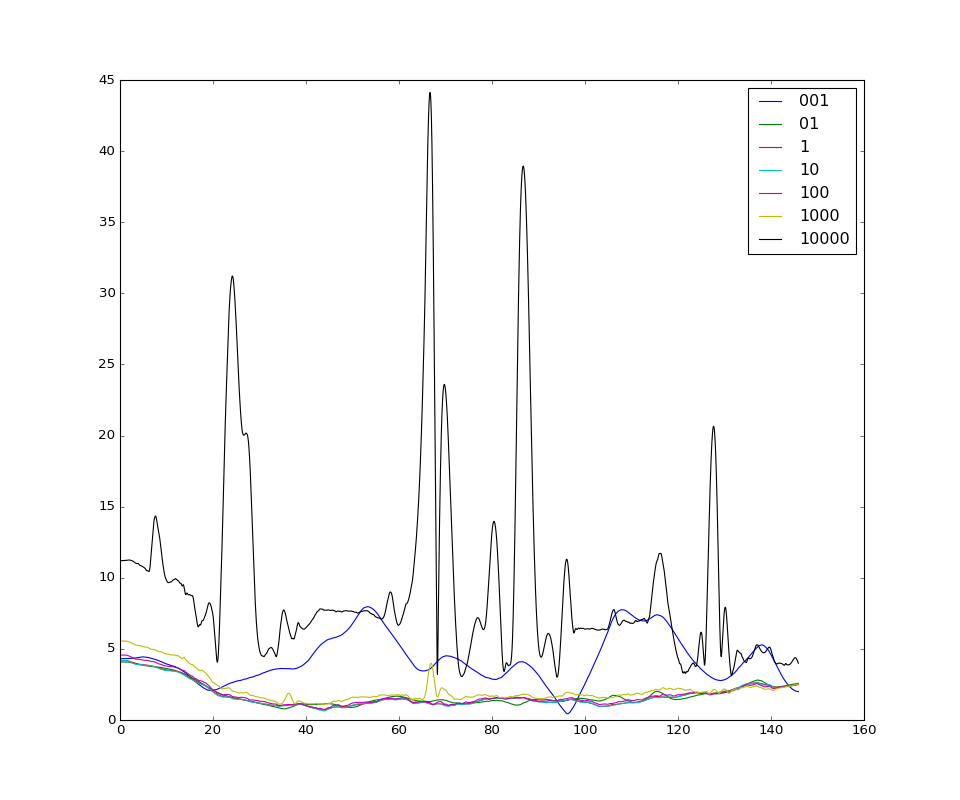

<IPython.core.display.Javascript object>


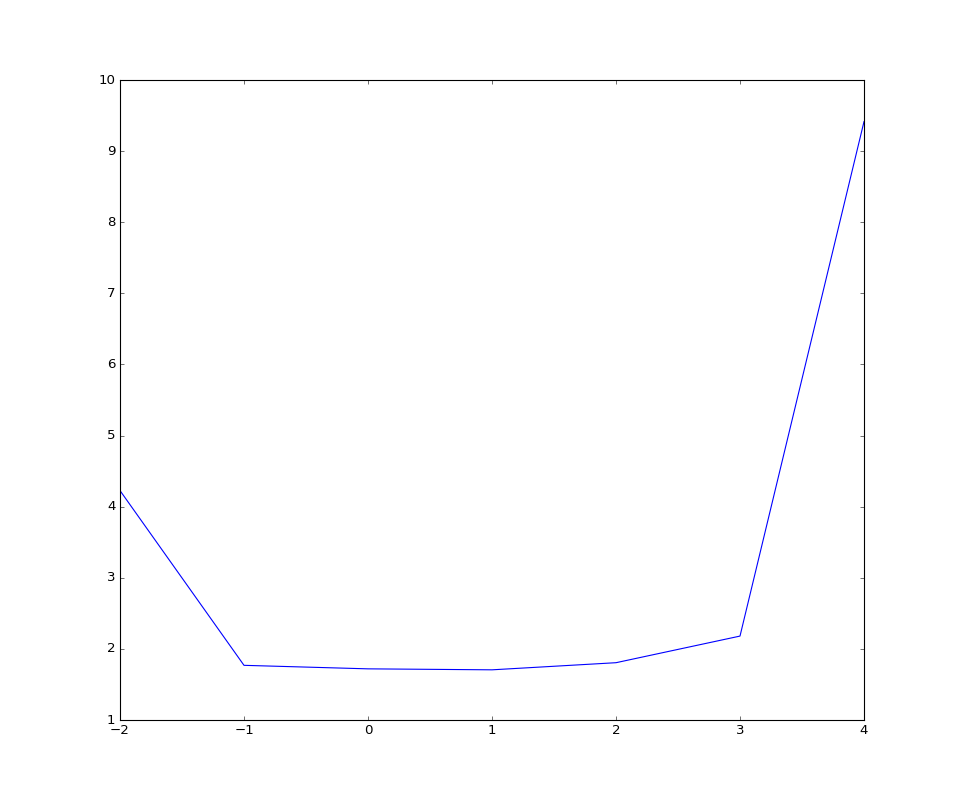

In [38]:
# different w_ls
weight_list = np.array([0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0])
suffix_list = ['001', '01', '1', '10', '100', '1000', '10000']
data_path = '../../data2/hang_bag_speed2/'
data_all = pandas.read_csv(data_path + '/processed/data.csv')
ts = data_all['time'].values
ts -= ts[0]
ts /= nano_to_sec
position = data_all[['pos_x', 'pos_y', 'pos_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values

loc_results = []
loc_error = []
for suffix in suffix_list:
    result = pandas.read_csv(data_path + '/result_{0}/result_{0}.csv'.format(suffix))
    estimated_traj = result[['pos_x', 'pos_y', 'pos_z']].values
    estimated_traj = global_transformation(estimated_traj, position)
    loc_results.append(estimated_traj)
    loc_error.append(np.linalg.norm(position - loc_results[-1], axis=1))
mean_positional_error = np.array([np.average(error_curve) for error_curve in loc_error])
print('Mean positional error: ', mean_positional_error)
plt.figure('Localization error with difference weight')
for i in range(len(loc_error)):
    plt.plot(ts, loc_error[i])
plt.legend(suffix_list)
plt.figure('Positional Error vs. Weights')
plt.plot(np.log10(weight_list), mean_positional_error)

In [16]:
# different baseline methods
# suffix_list = ['full', 'mag_only', 'ori_only', 'step']
suffix_list = ['hang', 'small']
data_path = '../../data/phab_body/shali_cse1/'
data_all = pandas.read_csv(data_path + '/processed/data.csv')
ts = data_all['time'].values
ts -= ts[0]
ts /= nano_to_sec
position = data_all[['pos_x', 'pos_y', 'pos_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values

track_length = sum(np.linalg.norm(position[1:] - position[:-1], axis=1))
print('Track length: ', track_length)
loc_results = []
loc_error = []

start_portion = 2000
for suffix in suffix_list:
    result = pandas.read_csv(data_path + '/result_{0}/result_{0}.csv'.format(suffix))
    estimated_traj = result[['pos_x', 'pos_y', 'pos_z']].values
    loc_results.append(estimated_traj)
    loc_error.append(np.linalg.norm(position - loc_results[-1], axis=1))

# read "raw" sapertely
# result_raw = pandas.read_csv(data_path + '/result_full/result_raw.csv')
# estimated_traj = result_raw[['pos_x', 'pos_y', 'pos_z']].values
# loc_results.append(estimated_traj)
# loc_error.append(np.linalg.norm(position - loc_results[-1], axis=1))

mean_positional_error = np.array([np.average(error_curve) for error_curve in loc_error])
print('Mean positional error: ', mean_positional_error)
error_percentage = mean_positional_error / track_length * 100
print('Error percentage: ', error_percentage)

# plt.figure('Localization error with difference preset')
# for i in range(len(loc_error)):
#     plt.plot(ts, loc_error[i])
# plt.legend(suffix_list)

Track length:  67.8276177985
Mean positional error:  [ 2.58398758  0.80939944]
Error percentage:  [ 3.8096393   1.19331839]


Writing Ply files...
Mean positional error: ar: 0.282343, estimated: 1.870028


<IPython.core.display.Javascript object>


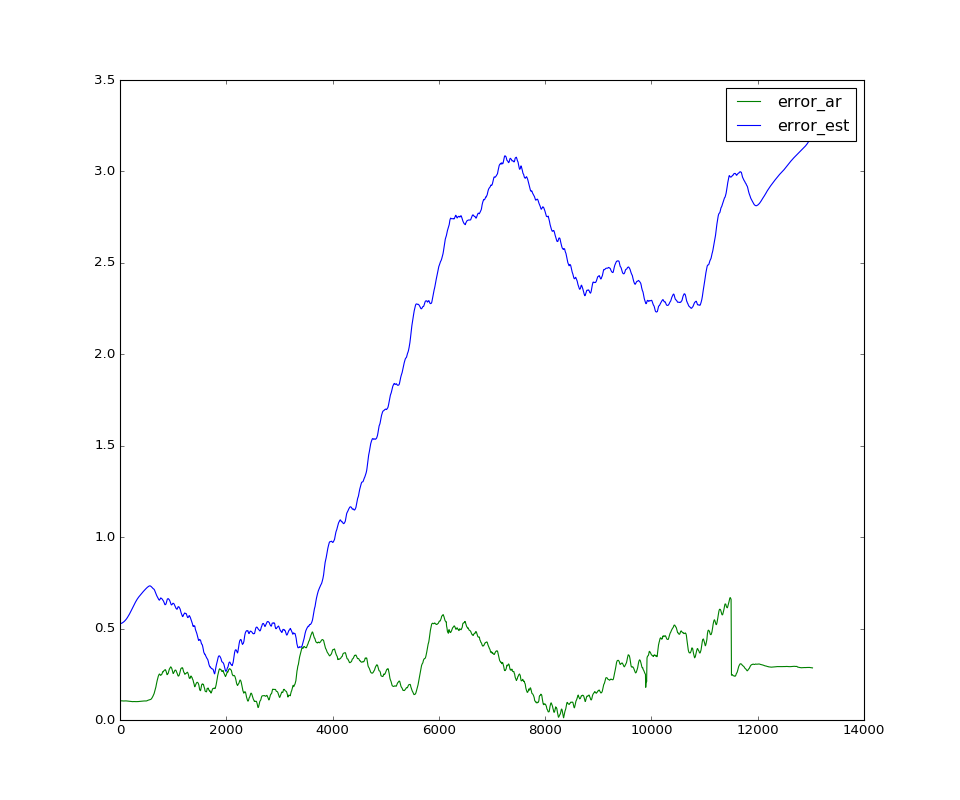

In [16]:
# For ARCore experiments
multi_root = '../../data_multi/hang_handheld_cse/'
data_all_ref = pandas.read_csv(multi_root + '/phab/processed/data.csv')
positions_ref = data_all_ref[['pos_x', 'pos_y', 'pos_z']].values
orientation_ref = data_all_ref[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values

traj_ar = pandas.read_csv(multi_root + '/pixel/processed/data.csv')
traj_ar = traj_ar[['pos_x', 'pos_y', 'pos_z']].values

traj_est = pandas.read_csv(multi_root + '/pixel/result_full/result_full.csv')
traj_est = traj_est[['pos_x', 'pos_y', 'pos_z']].values

start_length = 4000
traj_ar = global_transformation(traj_ar, positions_ref)

traj_est = global_transformation(traj_est, positions_ref)
_, R_2d, t_2d = icp.fit_transformation(traj_est[:start_length, :2], positions_ref[:start_length, :2])
traj_est[:, :2] = (np.dot(R_2d, traj_est[:, :2].T) + t_2d[:, None]).T

print('Writing Ply files...')
write_trajectory_to_ply.write_ply_to_file(multi_root + '/pixel/processed/reference.ply',
                                          positions_ref, orientation_ref, trajectory_color=(255, 0, 0),
                                          num_axis=1, length=0.8, interval=300)
write_trajectory_to_ply.write_ply_to_file(multi_root + '/pixel/processed/ar_transformed.ply',
                                          traj_ar, orientation_ref, trajectory_color=(0, 200, 0), 
                                          num_axis=1, length=0.8, interval=300)
write_trajectory_to_ply.write_ply_to_file(multi_root + '/pixel/result_full/estimated_transformed.ply',
                                          traj_est, orientation_ref, trajectory_color=(0, 0, 255),
                                          num_axis=1, length=0.8, interval=300)

error_ar = np.linalg.norm(traj_ar - positions_ref, axis=1)
error_est = np.linalg.norm(traj_est - positions_ref, axis=1)

print('Mean positional error: ar: %f, estimated: %f' % (np.mean(error_ar), np.mean(error_est)))
plt.figure('Positional error')
plt.plot(error_ar, color='g')
plt.plot(error_est, color='b')
plt.legend(['error_ar', 'error_est'])

<IPython.core.display.Javascript object>


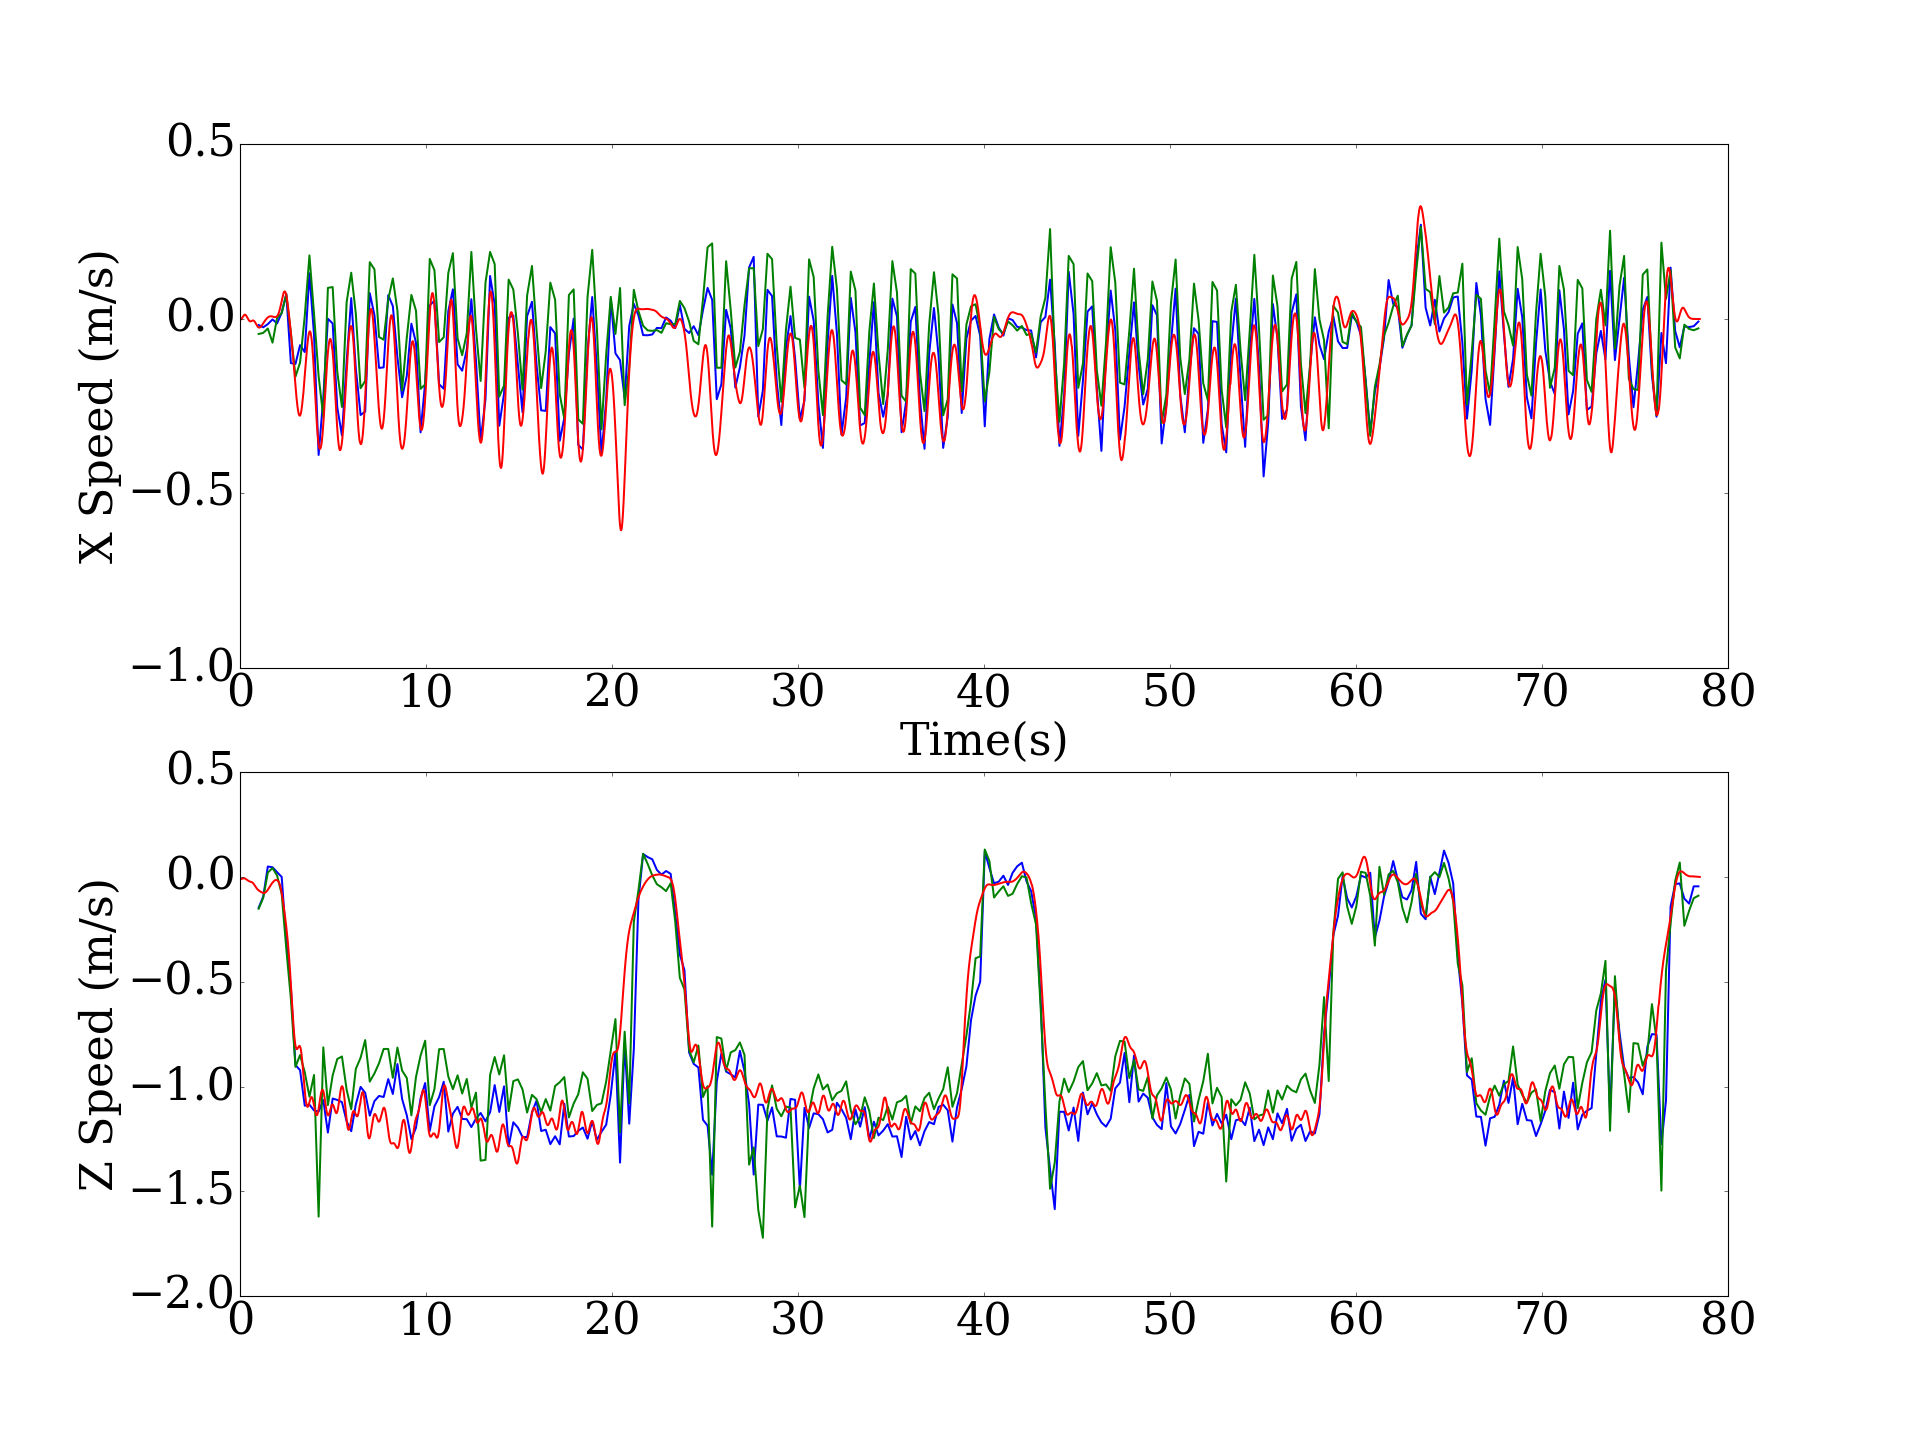

In [19]:
# cross subject experiments. Draw figures
filter_sigma = 30.0

data_dir = '../../data/phab_body/shali_cse2'

data_all = pandas.read_csv(data_dir + '/processed/data.csv')

positions = data_all[['pos_x', 'pos_y', 'pos_z']].values
orientations = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values
gravity = data_all[['grav_x', 'grav_y', 'grav_z']].values
ts = data_all['time'].values / nano_to_sec
ts -= ts[0]

ls_gt = td.compute_local_speed_with_gravity(ts, positions, orientations, gravity)
ls_gt = gaussian_filter1d(ls_gt, sigma=filter_sigma, axis=0)
ls_gt = ls_gt[:, [0, 2]]

regression_hang = np.genfromtxt(data_dir + '/result_hang/regression_hang.txt')
regression_small = np.genfromtxt(data_dir + '/result_small/regression_small.txt')

cid_hang = regression_hang[:, 0].astype(int)
cid_small = regression_small[:, 0].astype(int)
regression_hang = regression_hang[:, [1, 3]]
regression_small = regression_small[:, [1, 3]]

font = {'family': 'serif', 'size': 40}
plt.rc('font', **font)
    
ylabels = ['X Speed (m/s)', 'Z Speed (m/s)']
fig_ls = plt.figure('Local speed', figsize=(24, 18))
# fig_ls = plt.figure('Local Speed')

linewidth = 1.8

lines_hang = []
lines_small = []
lines_tango = []
for i in range(0, 2):
    plt.subplot(211+i)
    if i == 0:
        plt.xlabel('Time(s)')
    plt.ylabel(ylabels[i])
    plt.locator_params(nbins=5, axis='y')
    lines_small += plt.plot(ts[cid_small], regression_small[:, i], 'b', lw=linewidth)
    lines_hang += plt.plot(ts[cid_hang], regression_hang[:, i], 'g', lw=linewidth)
    lines_tango += plt.plot(ts, ls_gt[:, i], 'r', lw=linewidth)
#plt.figlegend([lines_hang[-1], lines_small[-1], lines_tango[-1]], ['Single', 'Full', 'Tango (Ground truth)'],
#              loc='upper center', ncol=2, labelspacing=0.)

fig_ls.savefig(data_dir + '/regression_crosssubject.png', bbox_inches='tight')